## Building a Naïve Bayes Classifier

We are going to develop a Naïve Bayes Classifier from scratch. We will learn about the Naïve Bayes algorithm and apply this to a practical use case to understand the working of this algorithm in more depth.


### What we will do in this exercise:

- Inspect and preprocess the Spam dataset.
- Implement a **Gaussian Naïve Bayes** (from first principles) because Spam features are continuous.
- Compute priors, per-class means & variances (likelihood parameters), and class posteriors for examples — show step-by-step numeric values.
- Evaluate performance and compare with scikit-learn's `GaussianNB`.

### Learning Objectives

We have the following learning objective for this exercise:

- Introduce the working structure of a custom Naïve Bayes classifier.

- Implement the model directly to understand its moving parts.

- Reinforce our understanding of prior, likelihood, and posterior probabilities.

### The Scenario: Spam Detection

We will use a binary example: classifying an email as Spam or Not Spam (often called "Ham"). We will use the `Spam` dataset. This dataset is a collection of filed spam emails, which include promotional and chained content. The dataset can be used for classification, and a trained model can be deployed to create a spam filter on emails. This can help determine if the email is spam or not. Includes 48 real attributes and totals 57 attributes. Attributes calculate word occurrence percentages as well.



**Now, let us get started ...**

### Setup — imports and constants

In [1]:
import numpy as np
import pandas as pd
from math import log, pi, exp, sqrt
from urllib.parse import urljoin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB

### Load the Spam dataset

In [2]:
df = pd.read_csv("/content/Spam.csv")
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_hash,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### Understand the labels and class balance

Label `1` = spam, `0` = not-spam.

In [3]:
counts = df['spam'].value_counts()
print(counts)
prior_spam = counts.get(1, 0) / len(df)
prior_ham = counts.get(0, 0) / len(df)
print(f'Prior P(spam) = {prior_spam:.4f}, P(ham) = {prior_ham:.4f} (based on dataset)')

spam
0    2788
1    1813
Name: count, dtype: int64
Prior P(spam) = 0.3940, P(ham) = 0.6060 (based on dataset)


### Split data into training and test sets

Next, to build our models and validate the trained model, we will divide our data into a training set and a test set.



In [4]:
X = df.drop(columns=['spam']).values
y = df['spam'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (3220, 57) Test shape: (1381, 57)


### Implement Gaussian Naïve Bayes from scratch

**Gaussian Naïve Bayes formula (per-feature):**


For a continuous feature $x$ and class $c$ with mean $\mu_{c}$ and variance $\sigma^2_{c}$,


$$
P(x \mid c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} \exp\left(-\frac{(x-\mu_c)^2}{2\sigma^2_c}\right)
$$


Naïve Bayes multiplies these per-feature likelihoods across features (we compute log-likelihoods and sum to avoid underflow).


We will implement a class that fits the mean & variance per feature for each class, and computes log-priors + log-likelihoods to produce log-posteriors.

In [5]:
class CustomGaussianNB:
  def __init__(self, var_smoothing=1e-9):
    self.var_smoothing = var_smoothing
    self.classes_ = None
    self.class_count_ = {}
    self.class_prior_ = {}
    self.mean_ = {}
    self.var_ = {}


  def fit(self, X, y):
    X = np.asarray(X)
    y = np.asarray(y)
    self.classes_ = np.unique(y)
    n_samples = X.shape[0]
    for c in self.classes_:
      Xc = X[y == c]
      self.class_count_[c] = Xc.shape[0]
      self.class_prior_[c] = Xc.shape[0] / n_samples
      self.mean_[c] = Xc.mean(axis=0)
      # add small smoothing to variance to avoid zero
      self.var_[c] = Xc.var(axis=0) + self.var_smoothing
    return self


  def _log_gaussian_pdf(self, X, mean, var):
    # Return log of Gaussian pdf for each sample and each feature
    # shape: (n_samples, n_features)
    coeff = -0.5 * np.log(2.0 * np.pi * var)
    exponent = -((X - mean) ** 2) / (2.0 * var)
    return coeff + exponent


  def predict_log_proba(self, X):
    X = np.asarray(X)
    n_samples = X.shape[0]
    log_probs = np.zeros((n_samples, len(self.classes_)))
    for idx, c in enumerate(self.classes_):
      log_prior = np.log(self.class_prior_[c])
      # compute per-feature log-likelihoods
      log_likelihood_features = self._log_gaussian_pdf(X, self.mean_[c], self.var_[c])
      # sum across features (Naive independence assumption)
      total_log_likelihood = log_likelihood_features.sum(axis=1)
      log_probs[:, idx] = log_prior + total_log_likelihood
    return log_probs


  def predict(self, X):
    log_probs = self.predict_log_proba(X)
    idx = np.argmax(log_probs, axis=1)
    return self.classes_[idx]

### Fit our CustomGaussianNB and evaluate

In [6]:
model = CustomGaussianNB(var_smoothing=1e-9)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print('Accuracy (custom NB):', accuracy_score(y_test, y_pred))
print('\nConfusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification report:')
print(classification_report(y_test, y_pred))

Accuracy (custom NB): 0.8196958725561188

Confusion matrix:
[[616 221]
 [ 28 516]]

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.74      0.83       837
           1       0.70      0.95      0.81       544

    accuracy                           0.82      1381
   macro avg       0.83      0.84      0.82      1381
weighted avg       0.86      0.82      0.82      1381



### Compare with scikit-learn's GaussianNB

Next, let us compare our implementation custom Naive Bayes with Scikit-learn's built in implementation

In [7]:
clf = GaussianNB(var_smoothing=1e-9)
clf.fit(X_train, y_train)
sk_pred = clf.predict(X_test)
print('Accuracy (scikit-learn GaussianNB):', accuracy_score(y_test, sk_pred))


# Brief check that results are similar
print('Difference in predictions count:', np.sum(sk_pred != y_pred))

Accuracy (scikit-learn GaussianNB): 0.8240405503258509
Difference in predictions count: 10


### Interpretation of priors, likelihoods and posteriors for a single test example


We pick one test row and compute:
- Empirical prior P(spam), P(ham)
- For the chosen sample, compute the per-feature log-likelihoods under each class (show a few features) and the total log-likelihood.
- Combine with log-prior to obtain the log-posterior (unnormalised). Optionally compute normalised posterior probabilities.

In [8]:
sample_idx = 0 # pick the first test sample
x_sample = X_test[sample_idx:sample_idx+1]
y_true = y_test[sample_idx]

In [9]:
print('True label:', y_true)
print(f"Empirical prior P(spam)={model.class_prior_[1]:.4f}, P(ham)={model.class_prior_[0]:.4f}")


log_probs_sample = model.predict_log_proba(x_sample).flatten()
for c, lp in zip(model.classes_, log_probs_sample):
  print(f'Class {c}: log-posterior (unnormalised) = {lp:.4f}')

True label: 0
Empirical prior P(spam)=0.3941, P(ham)=0.6059
Class 0: log-posterior (unnormalised) = -41.9024
Class 1: log-posterior (unnormalised) = -6148.3461


In [10]:
# Convert log-posteriors to normalised posteriors using softmax (numerically stable)
max_lp = np.max(log_probs_sample)
exp_vals = np.exp(log_probs_sample - max_lp)
posteriors = exp_vals / exp_vals.sum()
for c, p in zip(model.classes_, posteriors):
  print(f'Class {c}: posterior P(class|x) = {p:.6f}')

Class 0: posterior P(class|x) = 1.000000
Class 1: posterior P(class|x) = 0.000000


In [11]:
# Show per-feature contributions for the top 8 features (largest absolute difference in log-likelihood)
log_liks_spam = model._log_gaussian_pdf(x_sample, model.mean_[1], model.var_[1]).flatten()
log_liks_ham = model._log_gaussian_pdf(x_sample, model.mean_[0], model.var_[0]).flatten()
feature_diffs = log_liks_spam - log_liks_ham
top_idx = np.argsort(np.abs(feature_diffs))[-8:][::-1]

In [12]:
print('\nTop feature contributions (feature index, log_lik_spam, log_lik_ham, diff):')
for i in top_idx:
  print(i, f'{log_liks_spam[i]:.4f}', f'{log_liks_ham[i]:.4f}', f'{feature_diffs[i]:.4f}')


Top feature contributions (feature index, log_lik_spam, log_lik_ham, diff):
41 -5574.3689 -4.7389 -5569.6300
45 -470.8724 -4.1725 -466.6999
36 -65.2558 -16.3503 -48.9055
44 -47.8768 -3.3842 -44.4926
40 4.9566 -0.0384 4.9949
28 4.1352 -0.7103 4.8454
26 2.3093 -2.3984 4.7077
3 -1.6162 2.7700 -4.3862


### Visualise distribution of a selected feature for each class

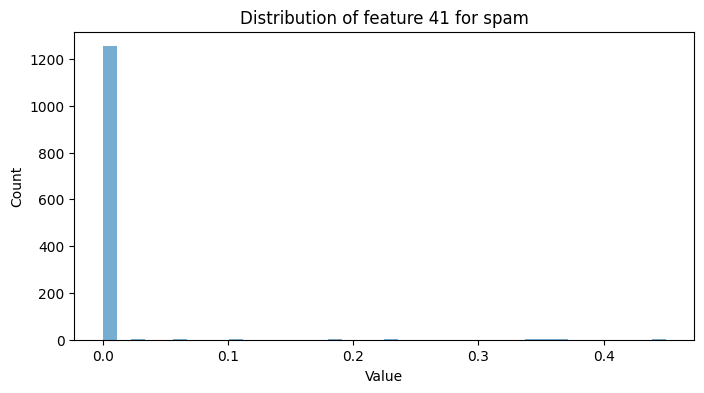

In [13]:
import matplotlib.pyplot as plt
feature_to_plot = top_idx[0]
plt.figure(figsize=(8,4))
plt.hist(X_train[y_train==1, feature_to_plot], bins=40, alpha=0.6)
plt.title(f'Distribution of feature {feature_to_plot} for spam')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

### Conclusion

In this exercise, we implemented a complete Naïve Bayes classifier from the ground up and applied it to the Spam dataset. By explicitly computing the priors, likelihoods, and posteriors, we observed how each probability contributes to the final classification of an email as spam or not-spam. This hands-on approach elaborates the mathematical intuition behind Naïve Bayes,  demonstrating how simple assumptions of independence can still yield powerful, interpretable, and efficient models for text-based problems. We should now be confident in both implementing and explaining each computational step of Naïve Bayes in practice.
